In [2]:
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import cvxpy as cp

import matplotlib.pyplot as plt
plt.style.use("ggplot")

import time

### kinematics model equations

The variables of the model are:

* $x$ coordinate of the robot
* $y$ coordinate of the robot
* $\theta$ heading of the robot
* $\psi$ heading error = $\psi = \theta_{ref} - \theta$
* $cte$ lateral error = distance of the robot from the path 

The inputs of the model are:

* $v$ linear velocity of the robot
* $w$ angular velocity of the robot

These are the differential equations f(x,u) of the model:

* $\dot{x} = v\cos{\theta}$ 
* $\dot{y} = v\sin{\theta}$
* $\dot{\theta} = w$
* $\dot{\psi} = -w$
* $\dot{cte} = v\sin{\psi}$

The **Continuous** State Space Model is

${\dot{x}} = Ax + Bu $

with:

$
A = \quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial x} & \frac{\partial f(x,u)}{\partial y} & \frac{\partial f(x,u)}{\partial \theta} & \frac{\partial f(x,u)}{\partial \psi} & \frac{\partial f(x,u)}{\partial cte} \\
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
0 & 0 & -vsin(\theta) & 0 & 0 \\
0 & 0 & vcos(\theta) & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & vcos(\psi) 
\end{bmatrix}
\quad
$

$
B = \quad
\begin{bmatrix}
\frac{\partial f(x,u)}{\partial v} & \frac{\partial f(x,u)}{\partial w} \\
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos{\theta_t} & 0 \\
\sin{\theta_t} & 0 \\
0 & 1 \\
0 & -1 \\
\sin{(-\psi_t)} & 0  
\end{bmatrix}
\quad
$

discretize with forward Euler Integration

* ${x_{t+1}} = x_{t} + v_t\cos{\theta}*dt$
* ${y_{t+1}} = y_{t} + v_t\sin{\theta}*dt$
* ${\theta_{t+1}} = \theta_{t} + w_t*dt$
* ${\psi_{t+1}} = \psi_{t} - w_t*dt$
* ${cte_{t+1}} = cte_{t} + v_t\sin{-\psi}*dt$

The **Discrete** State Space Model is

${x_{t+1}} = Ax_t + Bu_t $

with:

$
A = \quad
\begin{bmatrix}
1 & 0 & -v\sin{\theta}dt & 0 & 0 \\
0 & 1 & v\cos{\theta}dt & 0 & 0 \\
0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 +vcos{-\psi}dt
\end{bmatrix}
\quad
$

$
B = \quad
\begin{bmatrix}
\cos{\theta_t}dt & 0 \\
\sin{\theta_t}dt & 0 \\
0 & dt \\
0 & -dt \\
\sin{-\psi_t}dt & 0  
\end{bmatrix}
\quad
$

This State Space Model is not linear (A,B are time changing), to linearize it the **Taylor's series expansion** is used around $\bar{x}$ and $\bar{u}$:

$ \dot{x} = f(x,u) \approx f(\bar{x},\bar{u}) +  A(x-\bar{x}) + B(u-\bar{u})$

So:

$ x_{k+1} = x_k + (f(\bar{x},\bar{u}) +  A(x-\bar{x}) + B(u-\bar{u}) )dt $

$ x_{k+1} = (I+dtA)x_k + dtBu_k +dt(f(\bar{x},\bar{u}) - A\bar{x} - B\bar{u}))$

NB: psi and cte are expressed w.r.t. the reference point frame.
in the reference frame of the veicle the equtions would be:
* psi_dot = w
* cte_dot = sin(psi)

In [48]:
# Control problem statement.

N = 5 #number of state variables
M = 2 #number of control variables
T = 20 #Prediction Horizon
dt = 0.25 #discretization step

x = cp.Variable((N, T+1))
u = cp.Variable((M, T))

def get_model(x,u):
    
    x_t = x[0]
    y_t = x[1]
    theta_t = x[2]
    psi_t = x[3]
    cte_t = x[4]
    
    v_t = u[0]
    u_t = u[1]
    
    A = np.eye(N)
    A[0,2]=-v_t*np.sin(theta_t)*dt
    A[1,2]=v_t*np.cos(theta_t)*dt
    A[4,4]=1+v_t*np.cos(psi_t)*dt
    
    B = np.zeros((N,M))
    B[0,0]=np.cos(theta_t)*dt
    B[1,0]=np.sin(theta_t)*dt
    B[2,1]=dt
    B[3,1]=-dt
    B[4,0]=np.sin(-psi_t)*dt
    
    return A,B

In [71]:
def get_linear_model(x_bar,u_bar):
    
    x = x_bar[0]
    y = x_bar[1]
    theta = x_bar[2]
    psi = x_bar[3]
    cte = x_bar[4]
    
    v = u_bar[0]
    w = u_bar[1]
    
    A = np.zeros((N,N))
    A[0,2]=-v*np.sin(theta)
    A[1,2]=v*np.cos(theta)
    A[4,4]=v*np.cos(-psi)
    A_lin=np.eye(N)+dt*A
    
    B = np.zeros((N,M))
    B[0,0]=np.cos(theta)
    B[1,0]=np.sin(theta)
    B[2,1]=1
    B[3,1]=-1
    B[4,0]=np.sin(-psi)
    B_lin=dt*B
    
    f_xu=np.array([v*np.cos(theta),v*np.sin(theta),w,-w,v*np.sin(-psi)]).reshape(N,1)
    C_lin = dt*(f_xu - np.dot(A,x_bar.reshape(N,1)) - np.dot(B,u_bar.reshape(M,1)))
    
    return A_lin,B_lin,C_lin

In [4]:
get_model(np.zeros(N))

(array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]), array([[ 0.25,  0.  ],
        [ 0.  ,  0.  ],
        [ 0.  ,  0.25],
        [ 0.  , -0.25],
        [-0.  ,  0.  ]]))

Motion Prediction: using scipy intergration

In [50]:
# Define process model
def kinematics_model(x,t,u):

    # calculate derivative
    dxdt = u[0]*np.cos(x[2])
    dydt = u[0]*np.sin(x[2])
    dthetadt = u[1]
    dpsidt = -u[1]
    dctedt = u[0]*np.sin(-x[3])

    dqdt = [dxdt,
            dydt,
            dthetadt,
            dpsidt,
            dctedt]

    return dqdt

def predict(x0,u):
    """
    x0(5)
    u(2,T)
    
    x_bar(5,T+1)
    """
    
    x_bar = np.zeros((N,T+1))
    
    x_bar[:,0] = x0
    
    # solve ODE
    for t in range(1,T+1):

        tspan = [0,dt]
        x_next = odeint(kinematics_model,
                         x0,
                         tspan,
                         args=(u[:,t-1],))

        x0 = x_next[1]
        x_bar[:,t]=x_next[1]
        
    return x_bar

Validate the model, here the status w.r.t a straight line with constant heading 0

In [51]:
u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(-10) #rad/s

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(0)
x0[3] = 0
x0[4] = 1

x_bar=predict(x0,u_bar)

Check the model prediction

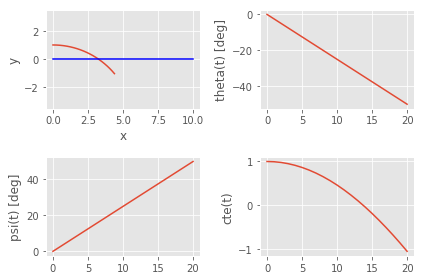

In [57]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(np.degrees(x_bar[2,:]))
plt.ylabel('theta(t) [deg]')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(np.degrees(x_bar[3,:]))
plt.ylabel('psi(t) [deg]')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

the results seems valid:
* the cte is correct
* theta error is correct

Motion Prediction: using the state space model

In [72]:
u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(-10) #rad/s

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(0)
x0[3] = 0
x0[4] = 1

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.dot(A,xt)+np.dot(B,ut)+C
    
    x_bar[:,t]= np.squeeze(xt_plus_one)

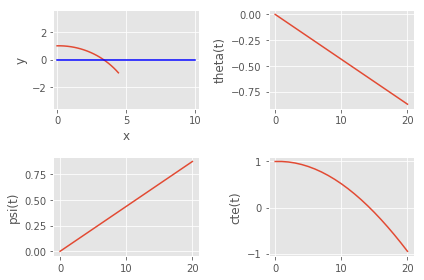

In [73]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(np.linspace(0,10,T+1),np.zeros(T+1),"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(x_bar[2,:])
plt.ylabel('theta(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(x_bar[3,:])
plt.ylabel('psi(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

The results are the same as expected

this way of predictiting psi and cte does not work for non-constant heading trajectories, appropriate functions have to be developed.

In [36]:
def calc_err(state,path):
    """
    Finds psi and cte w.r.t. the closest waypoint.

    :param state: array_like, state of the vehicle [x_pos, y_pos, theta]
    :param path: array_like, reference path ((x1, x2, ...), (y1, y2, ...), (th1 ,th2, ...)]
    :returns: (float,float)
    """

    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.sqrt(dx**2 + dy**2)
    nn_idx = np.argmin(dist)

    try:
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

#     front_axle_vect = [np.cos(state[2] - np.pi / 2),
#                        np.sin(state[2] - np.pi / 2)]
    path_ref_vect = [np.cos(path[2,target_idx] + np.pi / 2),
                     np.sin(path[2,target_idx] + np.pi / 2)]
    
    #heading error w.r.t path frame
    psi = path[2,target_idx] - state[2]
        
    # the cross-track error is given by the scalar projection of the car->wp vector onto the faxle versor
    #cte = np.dot([dx[target_idx], dy[target_idx]],front_axle_vect)
    cte = np.dot([dx[target_idx], dy[target_idx]],path_ref_vect)

    return target_idx,psi,cte

def compute_path_from_wp(start_xp, start_yp, step = 0.1):
    '''
    Interpolation range is computed to assure one point every fixed distance step [m].
    
    :param start_xp: array_like, list of starting x coordinates
    :param start_yp: array_like, list of starting y coordinates
    :param step: float, interpolation distance [m] between consecutive waypoints
    :returns: array_like, of shape (3,N)
    '''

    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,section_len/delta)
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        final_xp=np.append(final_xp,fx(interp_range))
        final_yp=np.append(final_yp,fy(interp_range))
        
    dx = np.append(0, np.diff(final_xp))
    dy = np.append(0, np.diff(final_yp))
    theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp,theta))

test it

In [75]:
track = compute_path_from_wp([0,5],[0,0])

u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(-10) #rad/s

x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(0)
_,psi,cte = calc_err(x0,track)
x0[3]=psi
x0[4]=cte

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
    
    _,psi,cte = calc_err(xt_plus_one,track)
    xt_plus_one[3]=psi
    xt_plus_one[4]=cte
    
    x_bar[:,t]= xt_plus_one

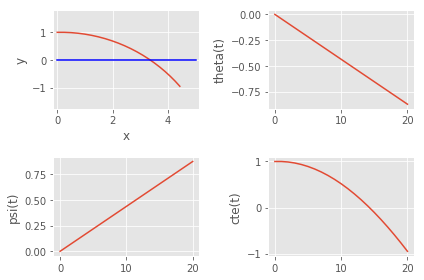

In [76]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(track[0,:],track[1,:],"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(x_bar[2,:])
plt.ylabel('theta(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(x_bar[3,:])
plt.ylabel('psi(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

In [79]:
track = compute_path_from_wp([0,2,4,5,10],[0,0,3,1,1])

u_bar = np.zeros((M,T))
u_bar[0,:] = 1 #m/s
u_bar[1,:] = np.radians(10) #rad/s

x0 = np.zeros(N)
x0[0] = 2
x0[1] = 2
x0[2] = np.radians(0)
_,psi,cte = calc_err(x0,track)
x0[3]=psi
x0[4]=cte

x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
    
    _,psi,cte = calc_err(xt_plus_one,track)
    xt_plus_one[3]=psi
    xt_plus_one[4]=cte
    
    x_bar[:,t]= xt_plus_one

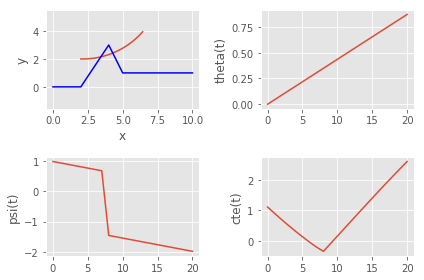

In [81]:
#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x_bar[0,:],x_bar[1,:])
plt.plot(track[0,:],track[1,:],"b-")
plt.axis('equal')
plt.ylabel('y')
plt.xlabel('x')

plt.subplot(2, 2, 2)
plt.plot(x_bar[2,:])
plt.ylabel('theta(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 3)
plt.plot(x_bar[3,:])
plt.ylabel('psi(t)')
#plt.xlabel('time')

plt.subplot(2, 2, 4)
plt.plot(x_bar[4,:])
plt.ylabel('cte(t)')

plt.tight_layout()
plt.show()

MPC Problem formulation


In [109]:
MAX_SPEED = 1.2
MIN_SPEED = 0.8
MAX_STEER_SPEED = 0.57

#starting guess
u_bar = np.zeros((M,T))
u_bar[0,:]=1
u_bar[1,:]=0.01

track = compute_path_from_wp([0,10],[2,2])

# Starting Condition
x0 = np.zeros(N)
x0[0] = 0
x0[1] = 1
x0[2] = np.radians(-30)
_,psi,cte = calc_err(x0,track)
x0[3]=psi
x0[4]=cte

start = time.time()

# Prediction
x_bar=np.zeros((N,T+1))
x_bar[:,0]=x0

for t in range (1,T+1):
    xt=x_bar[:,t-1].reshape(5,1)
    ut=u_bar[:,t-1].reshape(2,1)
    
    A,B,C=get_linear_model(xt,ut)
    
    xt_plus_one = np.squeeze(np.dot(A,xt)+np.dot(B,ut)+C)
    
    _,psi,cte = calc_err(xt_plus_one,track)
    xt_plus_one[3]=psi
    xt_plus_one[4]=cte
    
    x_bar[:,t]= xt_plus_one


#CVXPY MPC problem statement
cost = 0
constr = []

for t in range(T):
    
    # Cost function
    #cost += 10*cp.sum_squares( x[3, t]) # psi
    #cost += 50*cp.sum_squares( x[4, t]) # cte
    
    # Tracking
    idx,_,_ = calc_err(x_bar[:,t],track)
    delta_x =track[:,idx]-x[0:3,t]
    cost+= cp.quad_form(delta_x,10*np.eye(3))
    #cost += cp.quad_form( x[:, t],10*np.eye(N))
    
    # Actuation effort
    cost += cp.quad_form( u[:, t],1*np.eye(M))
    
    # Actuation rate of change
    if t < (T - 1):
        cost += cp.quad_form(u[:, t + 1] - u[:, t], 1*np.eye(M))
    
    #constrains
    A,B,C=get_linear_model(x_bar[:,t],u_bar[:,t])
    constr += [x[:,t+1] == A*x[:,t] + B*u[:,t] + C.flatten()]
    
# sums problem objectives and concatenates constraints.
constr += [x[:,0] == x0]
constr += [u[0, :] <= MAX_SPEED]
constr += [u[0, :] >= MIN_SPEED]
constr += [cp.abs(u[1, :]) <= MAX_STEER_SPEED]


prob = cp.Problem(cp.Minimize(cost), constr)
solution = prob.solve(solver=cp.ECOS, verbose=False)

end = time.time()

print(prob.status)
print("time elapsed: {}".format(end-start))

optimal
time elapsed: 0.2521398067474365


Print Results:

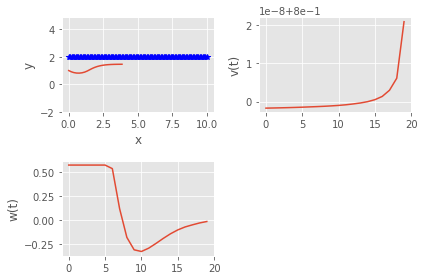

In [110]:
x_mpc=np.array(x.value[0, :]).flatten()
y_mpc=np.array(x.value[1, :]).flatten()
theta_mpc=np.array(x.value[1, :]).flatten()
psi_mpc=np.array(x.value[1, :]).flatten()
cte_mpc=np.array(x.value[1, :]).flatten()
v_mpc=np.array(u.value[0, :]).flatten()
w_mpc=np.array(u.value[1, :]).flatten()

#simulate q for optimized u_hat
x_traj=predict(x0, np.vstack((v_mpc,w_mpc)))

#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(track[0,:],track[1,:],"b*")
plt.plot(x_traj[0,:],x_traj[1,:])
plt.axis("equal")
plt.ylabel('y')
plt.xlabel('x')

#plot v(t)
plt.subplot(2, 2, 2)
plt.plot(v_mpc)
plt.ylabel('v(t)')
#plt.xlabel('time')

#plot w(t)
plt.subplot(2, 2, 3)
plt.plot(w_mpc)
plt.ylabel('w(t)')
#plt.xlabel('time')

#plot theta(t)
#plt.subplot(2, 2, 4)
#plt.plot(cte_mpc)
#plt.ylabel('cte(t)')
#plt.xlabel('time')
#plt.legend(loc='best')

plt.tight_layout()
plt.show()